# Assignment 5: Visualizing Data Veracity Challenges in Multi-Label Classification

In this assignment, I analyzed the Yeast dataset to explore data veracity challenges in multi-label classification, focusing on noisy labels, outliers, and hard-to-learn samples. Using **t-SNE and Isomap**, I reduced the high-dimensional gene expression data into two dimensions for visualization, enabling the detection of ambiguous points, isolated outliers, and regions of mixed categories that pose difficulties for classifiers. This study highlights both the local structure preservation of t-SNE and the global manifold learning of Isomap, offering insights into how data quality issues complicate model performance in biological applications.

## Part A: Preprocessing and Initial Setup 

#### Importing the necessary libraries
We start by importing the libraries required for the assignment.

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.neighbors import NearestNeighbors

### 1. Data Loading:

We load the data into pandas dataframe for further analysis.

In [2]:
# Load the ARFF file
data, meta = arff.loadarff("yeast.arff")

# Convert to a Pandas DataFrame
df = pd.DataFrame(data)

In [3]:
df.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,b'0',b'0',b'1',b'1',b'0',b'0',b'0',b'1',b'1',b'0'
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',b'0'
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,b'1',b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'


We can observe that Classes labels are like b'0' or b'1'. So we need to convert them to 0 or 1.

In [4]:
# Fix byte-string columns (decode b'0', b'1' → 0,1)
for col in df.columns:
    if df[col].dtype == object:  # b'0'/'b1'
        try:
            df[col] = df[col].str.decode("utf-8")   # decode bytes → str
            df[col] = pd.to_numeric(df[col])        # str → int
        except Exception:
            pass

In [5]:
df.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0,0,1,1,0,0,0,1,1,0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0,0,0,0,0,0,0,0,0,0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0,0,0,0,0,0,0,1,1,0
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,0,0,0,0,0,0,0,0,0,0
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,1,1,0,0,0,0,0,0,0,0


In [6]:
df.isnull().sum()

Att1       0
Att2       0
Att3       0
Att4       0
Att5       0
          ..
Class10    0
Class11    0
Class12    0
Class13    0
Class14    0
Length: 117, dtype: int64

Since there are no null values we can proceed.

In [7]:
X = df.iloc[:, :103].to_numpy()
Y = df.iloc[:, 103:].to_numpy()

### 2. Dimensionality Check:

In [12]:
n_samples, n_features = X.shape
n_labels = Y.shape[1]
print(f'Feature matrix X shape: {X.shape}')
print(f'Multi-label matrix Y shape: {Y.shape}')

Feature matrix X shape: (2417, 103)
Multi-label matrix Y shape: (2417, 14)


There are 103 features and 2417 data points.

### 3. Label Selection for Visualization:

To simplify the visualization (since 14 colors can be 
overwhelming), we are creating a new target variable for coloring that represents the two most frequent single-label classes and the most frequent multi-label combination and "Other" category to the rest. This approach creates a simple, distinct categorical index for coloring the plots.

In [13]:
# Find single-label instances (rows where sum==1)
sum_labels = Y.sum(axis=1)
single_mask = (sum_labels == 1)
indices_single = np.where(single_mask)[0]

single_label_counts = Counter()
for i in indices_single:
    lab = np.where(Y[i]==1)[0][0]
    single_label_counts[lab] += 1

# Top-2 most frequent single-label classes
most_common_single = [lab for lab, cnt in single_label_counts.most_common(2)]


# Most frequent multi-label combination (consider rows with >=2 labels)
multi_mask = (sum_labels >= 2)
multi_combos = Counter()
for i in np.where(multi_mask)[0]:
    combo = tuple(np.where(Y[i]==1)[0].tolist())
    multi_combos[combo] += 1

most_common_multi_combo = None
if len(multi_combos) > 0:
    most_common_multi_combo = multi_combos.most_common(1)[0][0]

print('Top-2 single-label classes (indices):', most_common_single)
print('Top multi-label combination (label indices):', most_common_multi_combo)

Top-2 single-label classes (indices): [np.int64(0)]
Top multi-label combination (label indices): (2, 3, 11, 12)


We can observe that there is only one **single-label class**(Class 0) and **Top multi-label combination** is (2, 3, 11, 12)

In [14]:
# Build a compact categorical index for coloring
# 0 -> top single 1, top single 2, 1-> top multi combo, 2 -> Other

target = np.full(n_samples, 2, dtype=int) # default Other
if most_common_single:
    target[[i for i in range(n_samples) if (sum_labels[i]==1 and np.where(Y[i]==1)[0][0]==most_common_single[0])]] = 0
if most_common_multi_combo is not None:
    combo_set = set(most_common_multi_combo)
    target[[i for i in range(n_samples) if set(np.where(Y[i]==1)[0].tolist()) == combo_set]] = 1


category_map = {
0: 'two most frequent single-label classes',
1: 'most frequent multi-label combination',
2: 'Other'
}

print('Category mapping (for plotting):')
for k,v in category_map.items():
    print(k, v)

Category mapping (for plotting):
0 two most frequent single-label classes
1 most frequent multi-label combination
2 Other


In [15]:
unique_vals, counts = np.unique(target, return_counts=True)
print(unique_vals, counts)  

[0 1 2] [  32  237 2148]


So there are 32 points in target 0, 237 points in target 1 and 2148 points in target 2(Other).

### 4. Scaling: 

Scaling is important for distance-based manifold methods because features with large numeric ranges would dominate pairwise distances, skewing nearest-neighbour relations. 

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Part B: t-SNE and Veracity Inspection

### 1. t-SNE Implementation: 

Applying t-Distributed Stochastic Neighbor Embedding (t-SNE) to the scaled feature matrix X to reduce it to 2 dimensions.

In [17]:
# This helper function runs t-SNE for multiple perplexities and produce visualizations side-by-side.
# Returns dict: perplexity -> embedding

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [18]:
def run_tsne_and_plot(X_scaled, target, category_map, perplexities, random_state=42):
    embeddings = {}
    
    n_plots = len(perplexities)
    
    if n_plots == 1:
        fig, ax = plt.subplots(figsize=(6, 5))
        axes = [ax]  # make it iterable
    else:
        n_cols = 2
        n_rows = int(np.ceil(n_plots / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
        axes = np.ravel(axes)  # flatten to 1D
        
    unique_labels = np.unique(target)
    n_classes = len(unique_labels)
    colors = plt.get_cmap('Set1', n_classes)
    
    for ax, p in zip(axes, perplexities):
        tsne = TSNE(n_components=2, perplexity=p, init='pca', random_state=random_state, learning_rate='auto')
        Z = tsne.fit_transform(X_scaled)
        embeddings[p] = Z
        
        for i, idx in enumerate(unique_labels):
            mask = target == idx
            ax.scatter(Z[mask,0], Z[mask,1], s=10, alpha=0.7, color=colors(i), label=f'{idx}:{category_map.get(idx)}')
        ax.set_title(f't-SNE (perplexity={p})')
        ax.legend(loc='best', fontsize='small')
    plt.tight_layout()
    plt.show()
    return embeddings

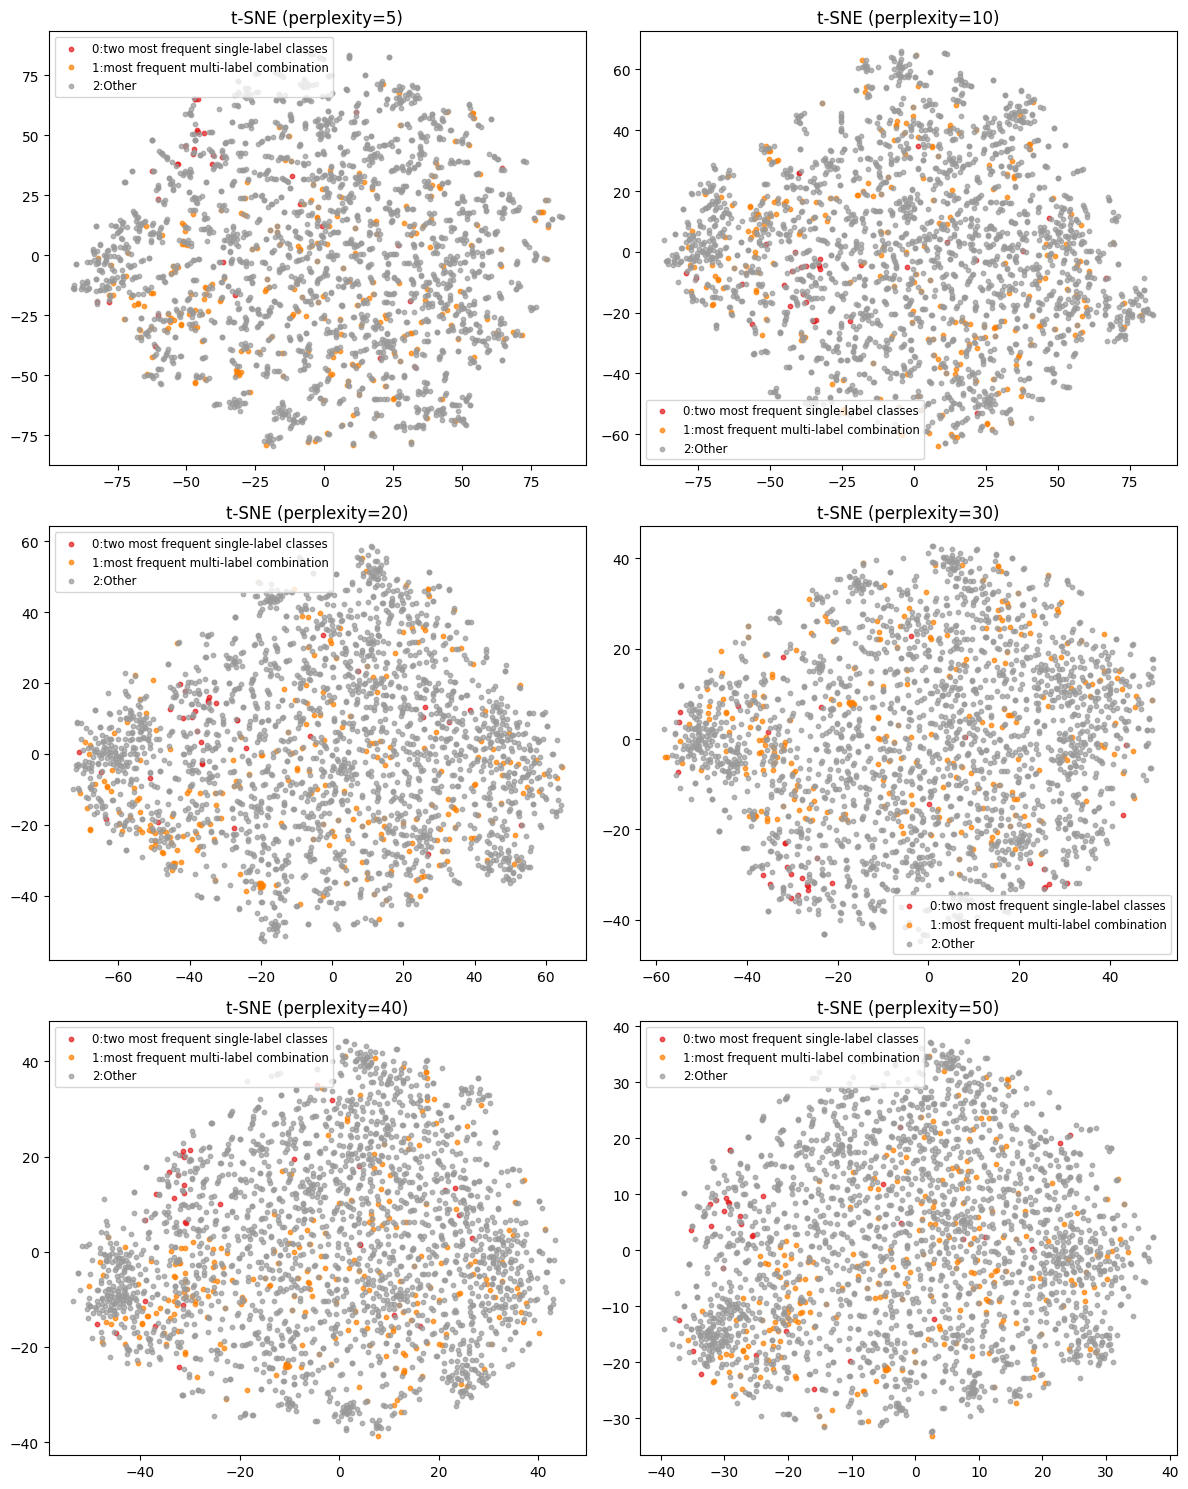

In [19]:
# Run t-SNE 
perps = [5, 10, 20, 30, 40, 50]
embeddings = run_tsne_and_plot(X_scaled, target, category_map, perplexities=perps)

We chose a **perplexity of 30** because it provides the **best trade-off between local and global structure preservation**. The clusters are more compact and interpretable compared to lower perplexities, while still avoiding the over-compression seen at higher values. This makes perplexity=30 the most meaningful setting for visualizing our dataset.

### 2. Visualization:

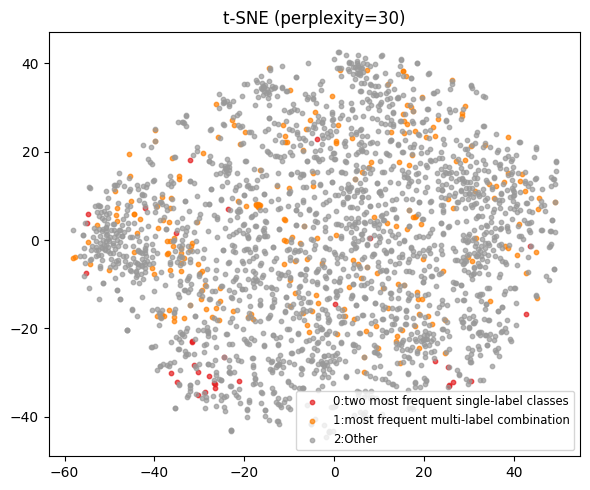

In [20]:
embeddings = run_tsne_and_plot(X_scaled, target, category_map, perplexities=[30])
Z_final = embeddings[30]

### 3. Veracity Inspection: 

We'll use neighborhood statistics in the *embedded space* (t-SNE coordinates) to highlight: noisy labels, outliers and hard-to-learn samples.

**a) Noisy/Ambiguous Labels:** Points where one color is deeply embedded within a 
cluster of a different color or a point whose label (category index) is different from the majority of its k neighbors.

In [21]:
k = 15
nbrs = NearestNeighbors(n_neighbors=k+1).fit(Z_final)  # +1 includes itself
distances, indices = nbrs.kneighbors(Z_final)

ambiguous_points = []
for i in range(len(target)):
    neigh_labels = target[indices[i][1:]]  # exclude self
    majority = np.bincount(neigh_labels).argmax()
    if target[i] != majority:
        ambiguous_points.append(i)

**b) Outliers:** Isolated points or tiny, distant clusters or points with unusually large average distance to k nearest neighbors (in original scaled space).

In [22]:
k_out = 10
distances, indices = nbrs.kneighbors(Z_final, n_neighbors=k_out)
outlier_scores = distances[:, -1]  # distance to farthest neighbor
threshold = np.percentile(outlier_scores, 95)  # top 5% are outliers
outliers = np.where(outlier_scores > threshold)[0]

**c) Hard-to-Learn Samples:** Areas where functional category colors are thoroughly 
mixed.

In [23]:
hard_samples = []
for i in range(len(target)):
    neigh_labels = target[indices[i][1:]]  # exclude self
    frac_majority = np.max(np.bincount(neigh_labels)) / k
    if frac_majority < 0.5:  # less than 50% same-class neighbors
        hard_samples.append(i)

In [24]:
print(f"Detected {len(ambiguous_points)} ambiguous, "
      f"{len(outliers)} outliers, {len(hard_samples)} hard-to-learn samples.")

Detected 269 ambiguous, 121 outliers, 654 hard-to-learn samples.


#### Plot final t-SNE embedding with overlays for noisy/outlier/hard-to-learn

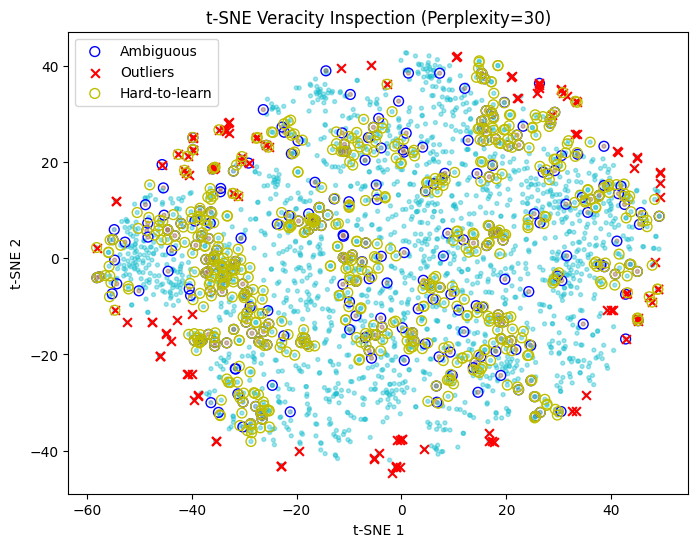

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(Z_final[:,0], Z_final[:,1], c=target, cmap="tab10", s=8, alpha=0.4)

# Overlay detected points
plt.scatter(Z_final[ambiguous_points,0], Z_final[ambiguous_points,1],
            edgecolors="b", facecolors="none", s=50, label="Ambiguous")
plt.scatter(Z_final[outliers,0], Z_final[outliers,1],
            marker="x", c="r", s=40, label="Outliers")
plt.scatter(Z_final[hard_samples,0], Z_final[hard_samples,1],
            edgecolors="y", facecolors="none", s=50, label="Hard-to-learn")

plt.title("t-SNE Veracity Inspection (Perplexity=30)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.show()

- **Noisy/Ambiguous Labels:** Points marked 'Ambiguous' are isolated inside regions dominated by another color. These might be genes with mislabeled functions, or genes that genuinely have overlapping biological roles. In practice these will cause a classifier to mislearn boundaries and increase label noise.
- **Outliers:** Marked points (x) are unusually distant in feature-space. They could correspond to experimental errors, rare conditions, or strongly perturbed expression profiles (e.g., a mutant or contamination). It is often justified to inspect or remove them, depending on domain knowledge.
- **Hard-to-Learn Samples:** They indicates neighborhoods where categories are mixed. Simple linear classifiers or independent binary classifiers (one-vs-rest) will likely have high error here. More advanced methods that capture label correlations or local decision boundaries might perform better.

## Part C: Isomap and Manifold Learning 

### 1. Isomap Implementation:

Applying Isomap to the scaled feature matrix X, reducing it to 2 dimensions.

In [26]:
isomap = Isomap(n_neighbors=10, n_components=2)
Iso_Z = isomap.fit_transform(X_scaled)

`Isomap` and `t-SNE` are both dimensionality reduction techniques, but they differ in what aspects of the data they preserve. **Isomap** focuses on maintaining the **global geometry** of the dataset by constructing a neighborhood graph, computing geodesic distances between points, and then applying classical multidimensional scaling (MDS). This ensures that the overall “shape” of the manifold is preserved. In contrast, **t-SNE** emphasizes preserving **local neighborhoods**. It converts pairwise similarities of points into probabilities and minimizes the Kullback-Leibler divergence between high- and low-dimensional representations. As a result, t-SNE is excellent for visualizing clusters and local patterns, but the relative distances between clusters can be distorted, whereas Isomap captures the global relationships more faithfully.

### 2. Visualization:

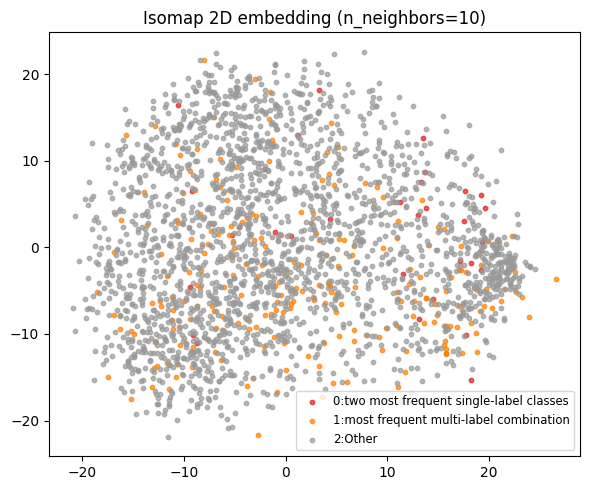

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

unique_labels = np.unique(target)
n_classes = len(unique_labels)
colors = plt.get_cmap('Set1', n_classes) 

for i, idx in enumerate(unique_labels):
    mask = target == idx
    ax.scatter(Iso_Z[mask, 0], Iso_Z[mask, 1], s=10, alpha=0.7, 
               color=colors(i), label=f'{idx}:{category_map.get(idx)}')

ax.set_title('Isomap 2D embedding (n_neighbors=10)')
ax.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

We tested with n=5, n=10 and n=15. The embedding with **n_neighbors = 10** strikes the best balance, preserving both local detail and global structure, while **n=5** fragments clusters and **n=15** oversmooths them.

### 3. Comparison and Curvature:

#### a) Isomap visualization v/s t-SNE visualization:

**Isomap (n_neighbors=10):-**
- **Strengths**:
  - Preserves **global geometry** by approximating geodesic distances on the data manifold.
  - Embedding is more "spread out" and continuous, retaining overall manifold structure.
  - Large-scale separation is visible, showing broad global variation.
- **Weaknesses**:
  - Local clusters are not tightly separated.
  - Neighborhood relationships are less compact compared to t-SNE.

**t-SNE (perplexity=30):-**
- **Strengths**:
  - Excels at preserving **local neighborhood structure**.
  - Tighter local grouping of similar points, making small clusters more distinct.
  - Highlights subtle local patterns.
- **Weaknesses**:
  - Distorts **global arrangement**, clusters may appear close even if distant in high-dimensional space.
  - Overall manifold structure is less faithfully represented.

**Conclusion:-**
- For studying **global structure** of gene expression data (overall variation, trajectories, large-scale trends): **Isomap is better**.  
- For studying **local structure** (fine-grained clustering, separation of similar samples): **t-SNE is better**.

Thus, Isomap is better at revealing the **global structure** of the gene expression data.

#### b) Data Manifold and Its Complexity:

**Concept of the Data Manifold:**
- In high-dimensional datasets (such as gene expression profiles), data points rarely fill the entire high-dimensional space. Instead, they tend to lie on a **lower-dimensional manifold**—a smooth, continuous surface embedded in the higher-dimensional space.  
- The goal of dimensionality reduction techniques like **Isomap** and **t-SNE** is to uncover and visualize this underlying manifold structure.
  
**Does the Isomap plot suggest a curved or complex manifold?**
- The Isomap plot shows that the data is **spread out smoothly** rather than concentrated in a few tight clusters. The embedding suggests the manifold is **not a simple flat plane** but is **curved and somewhat complex**, since Isomap had to preserve geodesic distances to spread out the points meaningfully.  
- If the manifold were simple and nearly linear, Isomap would produce a flatter, more uniformly distributed embedding.
  
**Relation to Classification Difficulty:**
- **Complex manifolds** often imply that different classes are interwoven along curved surfaces in high-dimensional space.  
- This increases classification difficulty because simple linear classifiers (e.g., logistic regression) may struggle to separate classes. Nonlinear decision boundaries are usually required.  
- In contrast, a **simpler manifold** would make classes easier to separate, often with linear methods.
  
**Conclusion:**
- The Isomap embedding suggests the data lies on a **curved, moderately complex manifold**.  
- This complexity explains why **classification is challenging** for gene expression data: classes are not cleanly separated by simple hyperplanes but require models that can capture nonlinear structures.